In [0]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from mnist_nn_utils import load_train_test_dataset, softmax, relu, relu_backward, softmax_backward
from optimization_algos import random_mini_batches
%load_ext autoreload
%autoreload 2

Length of the Y_train list:  60000


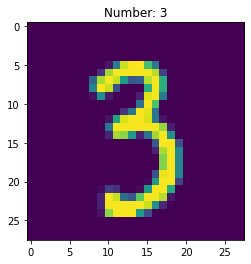

Length of the Y_test list:  10000

Numpy array X_train shape:  (784, 60000)

NUmpy array Y_train shape:  (1, 60000)

Numpy array X_test shape:  (784, 10000)

Numpy array Y_test shape:  (1, 10000)


In [0]:
X_train, Y_train, X_test, Y_test= load_train_test_dataset("Colab")

In [0]:
'''########### ONE HOT ENCODING OF Y_TRAIN #################

https://kite.com/python/answers/how-to-do-one-hot-encoding-with-numpy-in-python
'''
shape=(10,Y_train.size)

one_hot=np.zeros(shape)

rows=np.arange(Y_train.size)

'''
Now the one_hot is a matrix with rows equal to Y_train and the number of columns is same as number of classes.
one_hot[rows,Y_train]=1 ---- puts the value 1 at (row_number=rows,column_number=Y_train_value)
'''
one_hot[Y_train,rows]=1

print("Shape of One Hot encoding",one_hot.shape)

Y_train=one_hot  #Set Y_train to the encoded variable

Shape of One Hot encoding (10, 60000)


In [0]:
'''############### NORMALIZING THE INPUTS OF TRAIN AND TEST SET #################'''

X_train /= 255
X_test /= 255

**THE INITIALIZATION THAT WE PERFFORM HERE IS A SOLUTION TO THE VANISHING GRADIENTS PROBLEM**

> In our earlier Model we saw that there was a problem with Cost Function decreasing very slowly. The reason for such a problem can be the ReLU function that makes most of the terms zero and hence creating a Vanishing gradient problem. 



In [0]:
''' ########### INITIALIZATION OF L LAYERS IN DEEP NN(INITIALIZING FOR REDUCING VANISHING GRADIENT PROBLEM) ##############'''
def initialize_parameters_deep(layer_dims):
    
    '''Here layer_dims is a python list conataining the dimensions of all the layers'''
    np.random.seed(9)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        
        parameters["W"+str(l)]= np.random.randn(layer_dims[l], layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])
        parameters["b"+str(l)]= np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [0]:
'''############### FORWARD PROPAGATION MODULE for L Layers in "DEEP NN" ##################'''

def linear_forward(A, W, b):
    '''We build the LINEAR PART of the Forward Propagation'''
    Z= np.dot(W,A)+b
    
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    '''This function implements the ACTIVATION PART of the Forward Propagation'''
    
    if activation =="softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
        
    elif activation =="relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters,print_AL=False):
    '''
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    We use the above two functions in this function
    '''
    caches=[]
    A = X
    L = len(parameters)//2    ##number of layers in the neural net
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "softmax")
    caches.append(cache)
    
    if print_AL==True:
      print(AL)
    return AL, caches

In [0]:
'''############### COMPUTE COST ###############'''
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    max_val = np.max(AL, axis =0)
    exp_val = np.sum(np.exp(AL - max_val), axis =0)
    logsoftmax = (AL - max_val) - np.log(exp_val)
    cost = -(np.sum(np.multiply(Y,logsoftmax)))/m
    
    cost = np.squeeze(cost)
    return cost

In [0]:
'''################ BACKWARD PROPAGATION MODULE #############'''
def linear_backward(dZ, cache):
    '''Implement the linear portion of the Backward Propagation'''
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis =1, keepdims= True)/m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    
    grads={}
    m = AL.shape[1]
    
    Y = Y.reshape(AL.shape)
    
    L = len(caches)    ##number of layers in the neural net
    #print("L: ",L)
    out = np.zeros((10, m))
    dAL = -np.divide(Y,np.maximum(AL,1e-12), out=out, where=Y!=0)
    
    current_cache = caches[L-1]
    
    grads["dA"+str(L-1)], grads["dW"+str(L)], grads["db"+str(L)] = linear_activation_backward(dAL, current_cache, activation="softmax")
    
    #Loop from L-2 to 0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        #print("Value of l:",l)
        dA_prev_temp,dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)], current_cache, activation="relu")
        grads["dA"+str(l)] = dA_prev_temp
        grads["dW"+str(l+1)] = (dW_temp)/m
        grads["db"+str(l+1)] = (db_temp)/m

        #print("dA"+str(l)+":"+grads["dA"+str(l)],"\ndW"+str(l+1)+":"+grads["W"+str(l+1)],grads["b"+str(l+1)])
        
    return grads

In [0]:
'''################ UPDATE PARAMETERS ###################'''
def update_parameters(parameters, grads, learning_rate):
    
    L= len(parameters)//2
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate*grads["db"+str(l+1)]
        
    return parameters

In [0]:
'''############# DEFINING DIMENSIONS FOR THE LAYERS ##############'''
layers_dims = [X_train.shape[0], 800, 500, 128 , Y_train.shape[0]] #  4-layer model

In [0]:
'''################## L LAYER MODEL ###############'''
def L_layer_model(X, Y, layer_dims,learning_rate=0.076, mini_batch_size= 128,  num_epochs=500, print_cost=False):
    
    costs=[] #to plot the graph
    seed = 56
    m = X.shape[1]


    #Initialize Parameters
    parameters = initialize_parameters_deep(layer_dims)
    
    for i in range(num_epochs):
      seed = seed +1
      minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
      cost_total = 0

      for mini_batch in minibatches:
        #Select a mini_batch
        (minibatch_X, minibatch_Y) = mini_batch

        #Forward Propagation on mini_batch
        AL, caches = L_model_forward(minibatch_X, parameters)

        #Compute Cost and add to the total cost
        cost_total += compute_cost(AL, minibatch_Y)

        #Backward Propagation on mini_batch
        grads = L_model_backward(AL, minibatch_Y, caches)

        #Update Parameters of W & b
        parameters = update_parameters(parameters, grads, learning_rate)
        
      cost_avg = cost_total/m

      if print_cost and i%2 == 0:
        print ("Cost after epoch %i: %f" %(i, cost_avg))
        costs.append(cost_avg)

    '''Plot the Cost'''
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("Epochs (per hundred)")
    plt.title("Learning rate: "+str(learning_rate))
    plt.show()
    
    return parameters

In [0]:
parameters = L_layer_model(X_train, Y_train, layers_dims, mini_batch_size=2048, num_epochs= 10, print_cost = True)

In [0]:
########################### PREDICTION ####################
def predict(parameters, X):
    '''Use Forward Propagation and parameters to compute A2'''
    AL, cache = L_model_forward(X, parameters,print_AL=True)
    
    print("Shape of AL",AL.shape)
    print(AL[:,0:5])
    predictions = np.where(AL == np.amax(AL, axis=0))
    print(predictions)
    #the predictions ia a two tuple 
    return predictions[0]

In [0]:
######################## PREDICTION ON TEST SET #######################
Y2 = predict(parameters, X_test)
print(Y2.shape)

result = [Y2 == Y_test]

# result is a list, in which the first is an array of boolean values
#so we separate it out using result[0]
print(result[0])
count = np.count_nonzero(result[0]) ##Number of true values in the list accuracy
count

#accuracy

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Shape of AL (10, 10000)
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
(array([], dtype=int64), array([], dtype=int64))
(0,)
False


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


0